# Titanic - Machine Learning from Disaster
## Predicting survivors of the Titanic shipwreck

<p align='center'>
    <img src='img/titanic.jpg'>
</p>

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we want to build a model that predicts which passengers survived the Titanic shipwreck, using data (ie name, age, gender, socio-economic class, etc).

To solve the problem, we will follow these step:

- **0.0.** Data Collection.
- **1.0.** Data description.
- **2.0.** Feature Engineering
- **3.0.** Filtering the features
- **4.0.** Exploratory Data Analysis
- **5.0.** Data preparation
- **6.0.** Feature selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter fine tuning
- **9.0.** Translation and interpretation of the error
- **10.0.** Deploy model to production

# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.ensemble import RandomForestClassifier

## 0.1. Helper functions

in this step, we'll document all the functions that will be used to solve the problem.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

### Overview

Here we will import the data we will need to predict the survivors of the wreck.

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set will be used to build our machine learning models. Our model will be based on “characteristics” such as gender and class of passengers. We will also use feature engineering to create new features.

The test set will be used to see how well our model performs on unseen data. For each passenger in the test set, we'll use the model we've trained to predict whether or not they survived the sinking of the Titanic.

We also have gender_submission.csv, a set of predictions that assume all and only women survive, and we will use that as the baseline for our solution.

### Data Dictionary

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


### Data assumptions

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

We'll load **"train.csv"** and **"test.csv"** and unite them to build a dataframe that will call **"df_raw"**. 

In [32]:
train = pd.read_csv( 'datasets/titanic/train.csv' )
test = pd.read_csv( 'datasets/titanic/test.csv' )

df_raw = pd.concat( [train, test], axis=0 ).reset_index()

df_raw.sample()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
532,532,533,0.0,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C


# 1.0. Data Description

in this step we will perform the following tasks:

- Data Dimensions
- Data Types
- Check missing values
- Fillout missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [34]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

Let's see the size of the dataset dimensions.

In [64]:
# Train dataset
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1309
Number of columns: 12


## 1.2. Data Types

In this step we want to see what the data types are. This is important for us to treat the data correctly, and change them if necessary.

In [65]:
df_raw.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# 1.3. Check NA

In this step, we want to see if there are any missing values in the dataset. If so, we must solve this problem because our machine learning algorithms are not able to handle null values.

In [66]:
# Train dataset
df1.isna().sum().sort_values( ascending=False )

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

## 1.4. Fillout NA

As we saw in the previous step, there are four variables in the dataset that have missing values: Cabin, Age, Fare and Embarked.
We'll explain how to solve the problem in each variable.

- Cabin
    - This variable will probably not be useful for the predictive model and has a large number of missing values, so we will delete it.

- Age
    - For this variable we will use the mean or median.
    
- Fare
    - There is only one missing value in the test dataset, so in this case we will just fill with the mean.
    
- Embarked
    - There are only two missing values in the training dataset, so in this case let's just fill in the mode.

In [6]:
# Cabin 
df1.drop( 'Cabin', axis=1, inplace=True )

# Fare
df1['Fare'].fillna( format( np.mean( df1['Fare'] ), ".4f" ), inplace=True )

# Embarked
df1['Embarked'].fillna( df1['Embarked'].mode()[0], inplace=True )

Now, to fill in the missing values from the age column, we will first look at how the passengers' ages are distributed. As we can see, most passengers are in the 20 to 30 age range.

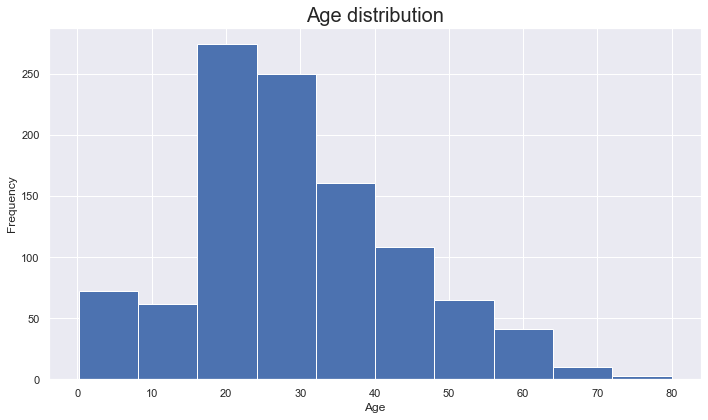

In [73]:
fig, ax = subplots( figsize=(10, 6) )

ax.hist( 'Age', data=df1 )
ax.set_title( 'Age distribution', fontsize=20 )
ax.set_xlabel( 'Age' )
ax.set_ylabel( 'Frequency' )

plt.tight_layout()

We will use a measure of centrality to fill in the missing values. However, we will first plot a boxplot to see if there are any outliers in the dataset. As we can see, both the training and testing datasets have outliers, so we will use the median as it is less affected by outliers.

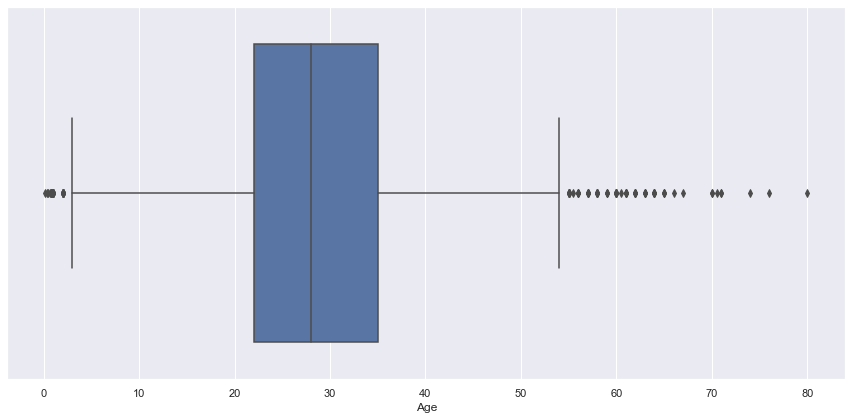

In [24]:
fig, ax = subplots( figsize=(12,6) )

sns.boxplot( x=df1['Age'], ax=ax )

plt.tight_layout()

In [75]:
print('Median:', int( df1['Age'].median() ) )

Median: 28


In [7]:
df1['Age'].fillna( df1['Age'].median(), inplace=True )

## 1.5. Descriptive Statistical

For this step we will separate the numeric and categorical variables.

In [36]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1[['Sex', 'Embarked']]

### 1.5.1. Numerical Attributes

For the numerical variables we use two types of analysis.

- Central tendency
    - average
    - median
    
- Dispersion
    - count
    - std - standard deviation
    - min
    - max
    - first quartile
    - third quartile

In [37]:
num_attributes.describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,369.478992,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,248.767105,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,163.000000,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,327.000000,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,563.000000,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,890.000000,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### 1.5.2. Categorical Attributes

For categorical variables we will use the countplot, which show the counts of observations in each categorical bin using bars.

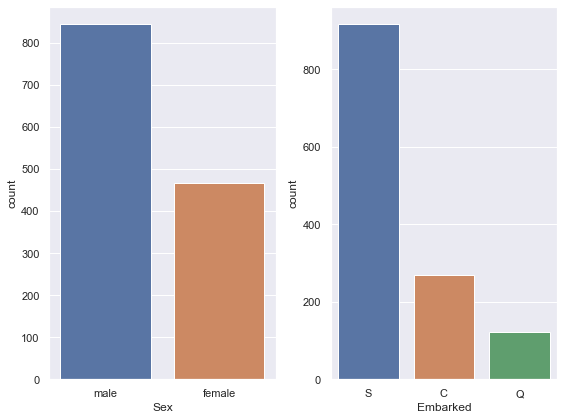

In [25]:
fig, ax = subplots( nrows=1, ncols=2, figsize=(8, 6) )
sns.countplot( x = cat_attributes['Sex'], ax=ax[0] )

sns.countplot( x = cat_attributes['Embarked'], ax=ax[1] )

plt.tight_layout()